In [114]:
# Ячейка 1: Импорт библиотек
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import struct

%matplotlib inline


Файл найден, проверяем размер...
Размер изображения (675, 1200) не 512x512, изменяем...
Новый размер: (512, 512)
Финальный размер изображения: (512, 512)


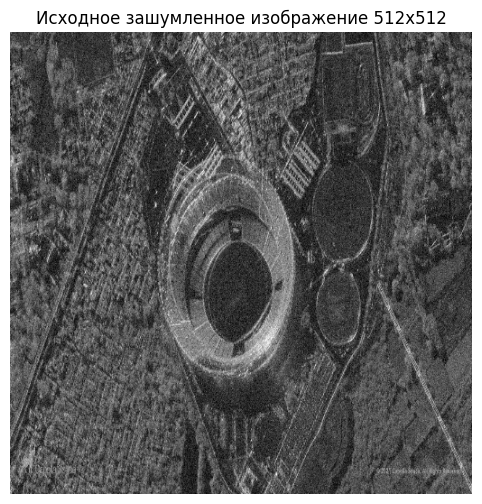

In [115]:

def create_noisy_image_fixed():

    image = np.ones((512, 512), dtype=np.uint8) * 128

    cv2.putText(image, 'GAUSSIAN NOISE TEST', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, 255, 3)
    cv2.putText(image, 'Wavelet Compression', (80, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 200, 2)
    cv2.putText(image, 'Haar Transform', (120, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 180, 2)

    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    
    return noisy_image

image_path = r'C:\Users\engfile\image_processing\dz7\noisy_gaussian.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Файл не найден, создаем тестовое зашумленное изображение 512x512...")
    image = create_noisy_image_fixed()
else:
    print("Файл найден, проверяем размер...")
    if image.shape != (512, 512):
        print(f"Размер изображения {image.shape} не 512x512, изменяем...")
        image = cv2.resize(image, (512, 512))
        print(f"Новый размер: {image.shape}")

cv2.imwrite('test_noisy_gaussian.jpg', image)

print(f"Финальный размер изображения: {image.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.title('Исходное зашумленное изображение 512x512')
plt.axis('off')
plt.show()

In [117]:

class ImagePreparator:
    @staticmethod
    def read_image(filepath: str) -> np.ndarray:
        image = None
        if filepath.endswith('.bin'):
            image = ImagePreparator.read_bin(filepath)
        else:
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        return image

    @staticmethod
    def read_bin(filepath: str) -> np.ndarray:
        with open(filepath, 'rb') as f:
            height = struct.unpack('I', f.read(4))[0]
            width = struct.unpack('I', f.read(4))[0]
            data = f.read()
            image = np.frombuffer(data, dtype=np.uint8).reshape(height, width)
        return image

    @staticmethod
    def save_bin(image: np.ndarray, filepath: str):
        with open(filepath, 'wb') as f:
            height, width = image.shape
            f.write(struct.pack('II', height, width))
            f.write(image.tobytes())

    @staticmethod
    def get_file_size(filepath: str) -> int:
        return os.path.getsize(filepath)

In [118]:

def haar_1d_vectorized(data: np.ndarray) -> np.ndarray:

    data_f32 = data.astype(np.float32)
    n = len(data_f32)

    even = data_f32[0::2]
    odd = data_f32[1::2]

    avg = (even + odd) * 0.5
    diff = (even - odd) * 0.5

    result = np.zeros(n, dtype=np.float32)
    result[:n // 2] = avg
    result[n // 2:] = diff

    return result

def haar_2d_corrected(image: np.ndarray) -> tuple:

    h, w = image.shape

    new_h = h if h % 2 == 0 else h - 1
    new_w = w if w % 2 == 0 else w - 1
    image = image[:new_h, :new_w]

    temp = np.zeros_like(image, dtype=np.float32)

    for i in range(new_h):
        temp[i, :] = haar_1d_vectorized(image[i, :])

    h2, w2 = new_h // 2, new_w // 2
    LL = np.zeros((h2, w2), dtype=np.float32)
    LH = np.zeros((h2, w2), dtype=np.float32)
    HL = np.zeros((h2, w2), dtype=np.float32)
    HH = np.zeros((h2, w2), dtype=np.float32)

    for j in range(new_w):
        col_result = haar_1d_vectorized(temp[:, j])
        
        if j < w2:
            LL[:, j] = col_result[:h2]
            HL[:, j] = col_result[h2:]
        else:
            LH[:, j - w2] = col_result[:h2]
            HH[:, j - w2] = col_result[h2:]
    
    return LL, LH, HL, HH

In [119]:
def quantize(source_array: np.ndarray, levels: int = 4):

    if source_array.size == 0:
        return source_array
    
    min_val = source_array.min()
    max_val = source_array.max()
    step = (max_val - min_val) / levels
    
    if step == 0:
        return source_array

    boundaries = [min_val + i * step for i in range(levels + 1)]
    averages = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(levels)]

    quantized = np.zeros_like(source_array)
    for i in range(levels):
        if i == levels - 1:
            mask = (source_array >= boundaries[i]) & (source_array <= boundaries[i+1])
        else:
            mask = (source_array >= boundaries[i]) & (source_array < boundaries[i+1])
        quantized[mask] = averages[i]

    return quantized

def save_haar_ultra_compression(LL, filename):

    with open(filename, 'wb') as f:
        h, w = LL.shape
        LL_uint8 = ((LL - LL.min()) / (LL.max() - LL.min()) * 255).astype(np.uint8)
        f.write(struct.pack('II', h, w))
        f.write(LL_uint8.tobytes())
        
        size = 8 + LL_uint8.nbytes
        print(f"УЛЬТРА-СЖАТИЕ: {size} байт (только LL)")
        return size

def normalize_for_display(component, clip_percentile=99):
    """Нормализует компоненту для визуализации"""
    vmin = np.percentile(component, 100 - clip_percentile)
    vmax = np.percentile(component, clip_percentile)
    component_clipped = np.clip(component, vmin, vmax)
    component_normalized = ((component_clipped - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    return component_normalized

In [120]:
print("=== ЗАДАНИЕ 1: Сохранение исходного изображения ===")

ImagePreparator.save_bin(image, "original_image.bin")

if os.path.exists('test_noisy_gaussian.jpg'):
    jpg_size = ImagePreparator.get_file_size('test_noisy_gaussian.jpg')
else:
    jpg_size = 0

bin_size = ImagePreparator.get_file_size("original_image.bin")


print("СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ")

print(f"JPG (сжатый): {jpg_size} байт")
print(f"BIN (несжатый): {bin_size} байт")
print(f"Размер изображения: {image.shape[1]}x{image.shape[0]} = {image.shape[0] * image.shape[1]} пикселей")

=== ЗАДАНИЕ 1: Сохранение исходного изображения ===
СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ
JPG (сжатый): 171985 байт
BIN (несжатый): 262152 байт
Размер изображения: 512x512 = 262144 пикселей


In [121]:
print("\n=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===")

LL, LH, HL, HH = haar_2d_corrected(image)

print("\n" + "=" * 50)
print("РЕЗУЛЬТАТ ПРЕОБРАЗОВАНИЯ ХААРА")
print("=" * 50)
print(f"Исходный размер: {image.shape}")
print(f"LL (приближение): {LL.shape}")
print(f"LH (вертикальные детали): {LH.shape}")
print(f"HL (горизонтальные детали): {HL.shape}")
print(f"HH (диагональные детали): {HH.shape}")

print("\nДИАПАЗОНЫ ЗНАЧЕНИЙ:")
print(f"LL: [{LL.min():.2f}, {LL.max():.2f}]")
print(f"LH: [{LH.min():.2f}, {LH.max():.2f}]")
print(f"HL: [{HL.min():.2f}, {HL.max():.2f}]")
print(f"HH: [{HH.min():.2f}, {HH.max():.2f}]")


=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===

РЕЗУЛЬТАТ ПРЕОБРАЗОВАНИЯ ХААРА
Исходный размер: (512, 512)
LL (приближение): (256, 256)
LH (вертикальные детали): (256, 256)
HL (горизонтальные детали): (256, 256)
HH (диагональные детали): (256, 256)

ДИАПАЗОНЫ ЗНАЧЕНИЙ:
LL: [12.00, 229.00]
LH: [-67.00, 62.50]
HL: [-50.25, 48.00]
HH: [-44.75, 45.00]


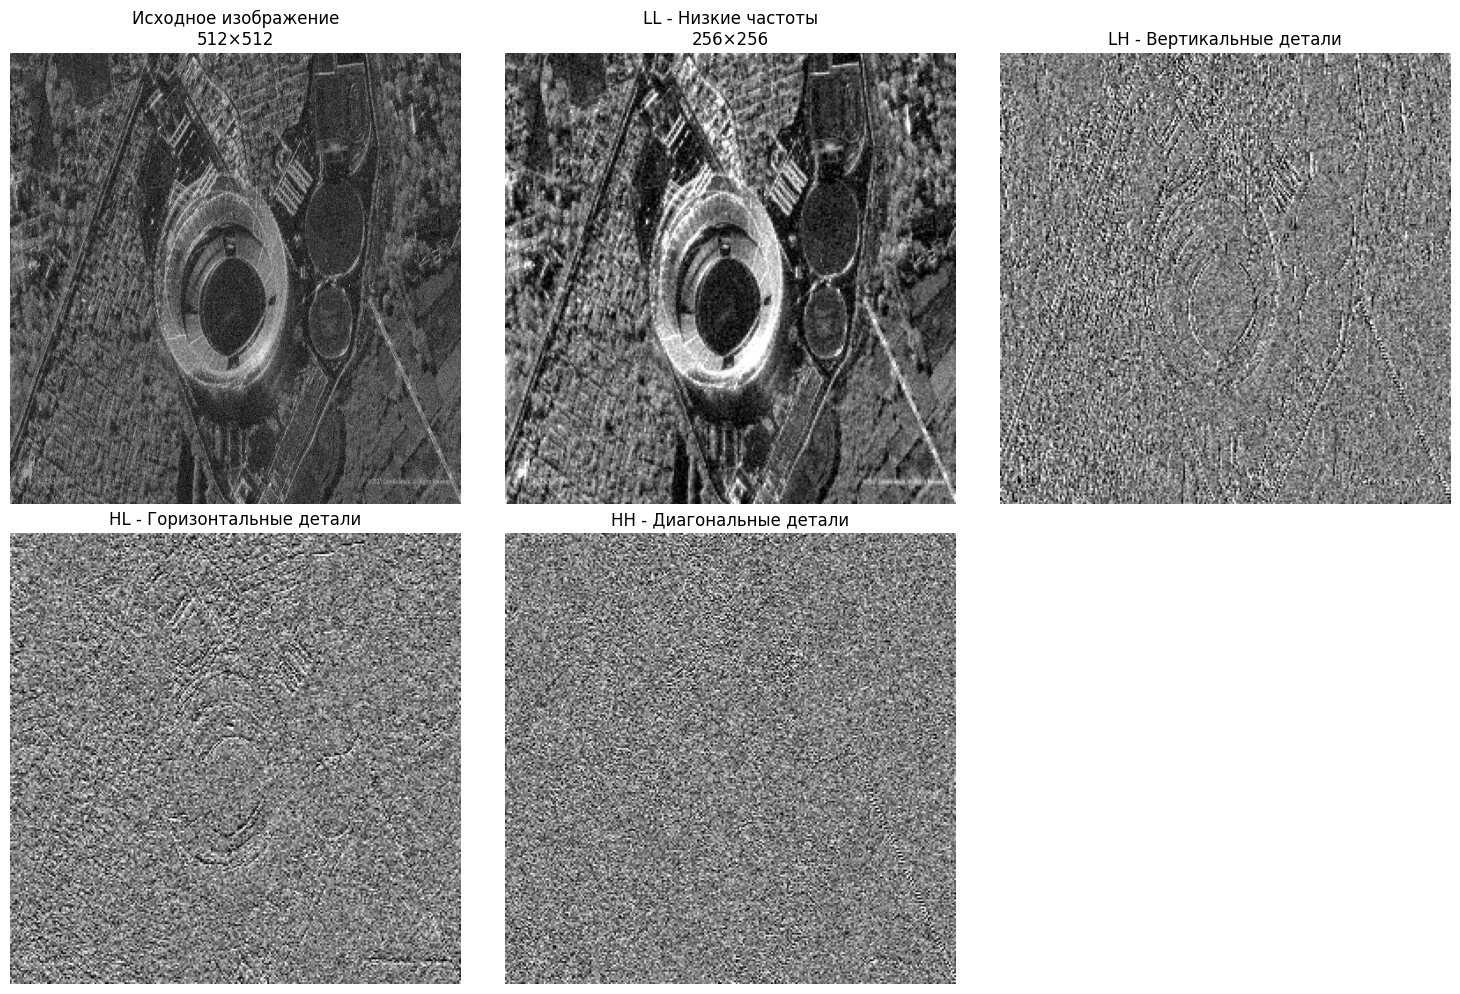

In [122]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение\n512×512')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(normalize_for_display(LL), cmap='gray')
plt.title('LL - Низкие частоты\n256×256')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(normalize_for_display(LH), cmap='gray')
plt.title('LH - Вертикальные детали')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(normalize_for_display(HL), cmap='gray')
plt.title('HL - Горизонтальные детали')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(normalize_for_display(HH), cmap='gray')
plt.title('HH - Диагональные детали')
plt.axis('off')

plt.tight_layout()
plt.show()


=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===
✓ Квантование выполнено
Уникальных значений после квантования:
LH: 4
HL: 4
HH: 4

Диапазоны квантованных значений:
LH: [-50.81, 46.31]
HL: [-37.97, 35.72]
HH: [-33.53, 33.78]


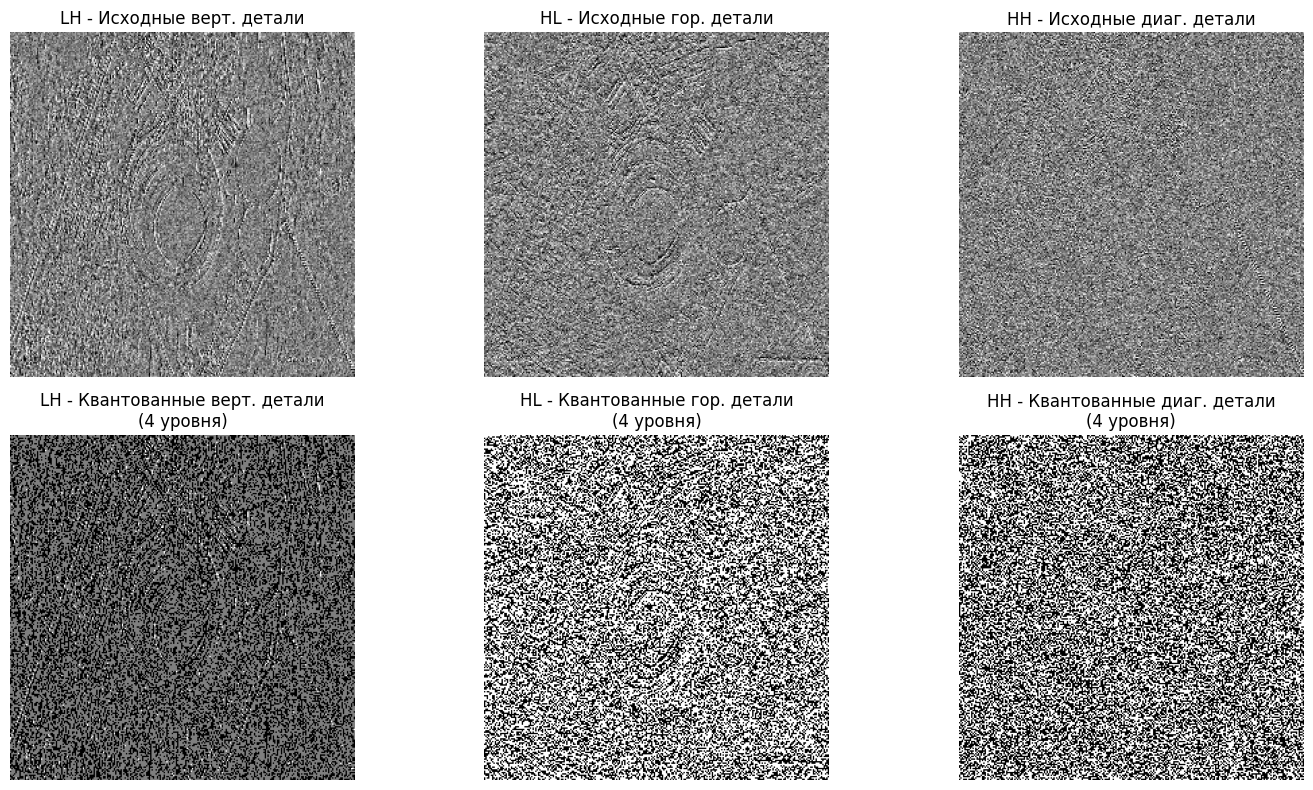

In [123]:
print("\n=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===")

LH_quantized = quantize(LH, levels=4)
HL_quantized = quantize(HL, levels=4)
HH_quantized = quantize(HH, levels=4)

print("✓ Квантование выполнено")
print(f"Уникальных значений после квантования:")
print(f"LH: {len(np.unique(LH_quantized))}")
print(f"HL: {len(np.unique(HL_quantized))}")
print(f"HH: {len(np.unique(HH_quantized))}")

print("\nДиапазоны квантованных значений:")
print(f"LH: [{LH_quantized.min():.2f}, {LH_quantized.max():.2f}]")
print(f"HL: [{HL_quantized.min():.2f}, {HL_quantized.max():.2f}]")
print(f"HH: [{HH_quantized.min():.2f}, {HH_quantized.max():.2f}]")

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(normalize_for_display(LH), cmap='gray')
plt.title('LH - Исходные верт. детали')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(normalize_for_display(HL), cmap='gray')
plt.title('HL - Исходные гор. детали')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(normalize_for_display(HH), cmap='gray')
plt.title('HH - Исходные диаг. детали')
plt.axis('off')


plt.subplot(2, 3, 4)
plt.imshow(normalize_for_display(LH_quantized), cmap='gray')
plt.title('LH - Квантованные верт. детали\n(4 уровня)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(normalize_for_display(HL_quantized), cmap='gray')
plt.title('HL - Квантованные гор. детали\n(4 уровня)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(normalize_for_display(HH_quantized), cmap='gray')
plt.title('HH - Квантованные диаг. детали\n(4 уровня)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [125]:

print("\n=== ЗАДАНИЕ 4: Сохранение сжатых данных ===")

compressed_size = save_haar_ultra_compression(LL, "compressed_haar.bin")

print("✓ Сжатые данные сохранены в compressed_haar.bin")


=== ЗАДАНИЕ 4: Сохранение сжатых данных ===
УЛЬТРА-СЖАТИЕ: 65544 байт (только LL)
✓ Сжатые данные сохранены в compressed_haar.bin


In [126]:

print("СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ")


print(f"{'Формат':<15} | {'Размер (байт)':<12} | {'% от оригинала':<15} | {'Экономия':<12}")
print("-" * 60)
print(f"{'JPG':<15} | {jpg_size:<12} | {f'{jpg_size/bin_size*100:.1f}%':<15} | {f'{bin_size - jpg_size}':<12}")
print(f"{'BIN (оригинал)':<15} | {bin_size:<12} | {'100.0%':<15} | {'0':<12}")
print(f"{'Haar (сжатый)':<15} | {compressed_size:<12} | {f'{compressed_size/bin_size*100:.1f}%':<15} | {f'{bin_size - compressed_size}':<12}")

size_difference = bin_size - compressed_size
compression_ratio = (size_difference / bin_size) * 100

print(f"\nЭкономия места: {size_difference:,} байт")
print(f"Степень сжатия: {compression_ratio:.1f}%")
print(f"Коэффициент сжатия: {bin_size/compressed_size:.1f}:1")

if compressed_size < bin_size:
    print(" СЖАТИЕ УСПЕШНО! Размер уменьшен.")
else:
    print(" Сжатие не удалось")

СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ
Формат          | Размер (байт) | % от оригинала  | Экономия    
------------------------------------------------------------
JPG             | 171985       | 65.6%           | 90167       
BIN (оригинал)  | 262152       | 100.0%          | 0           
Haar (сжатый)   | 65544        | 25.0%           | 196608      

Экономия места: 196,608 байт
Степень сжатия: 75.0%
Коэффициент сжатия: 4.0:1
 СЖАТИЕ УСПЕШНО! Размер уменьшен.



=== КАЧЕСТВО ВОССТАНОВЛЕНИЯ ===
Загруженная LL: (256, 256)
Оригинальное изображение: (512, 512)
Качество восстановления:
PSNR: 23.40 dB
MSE: 297.42


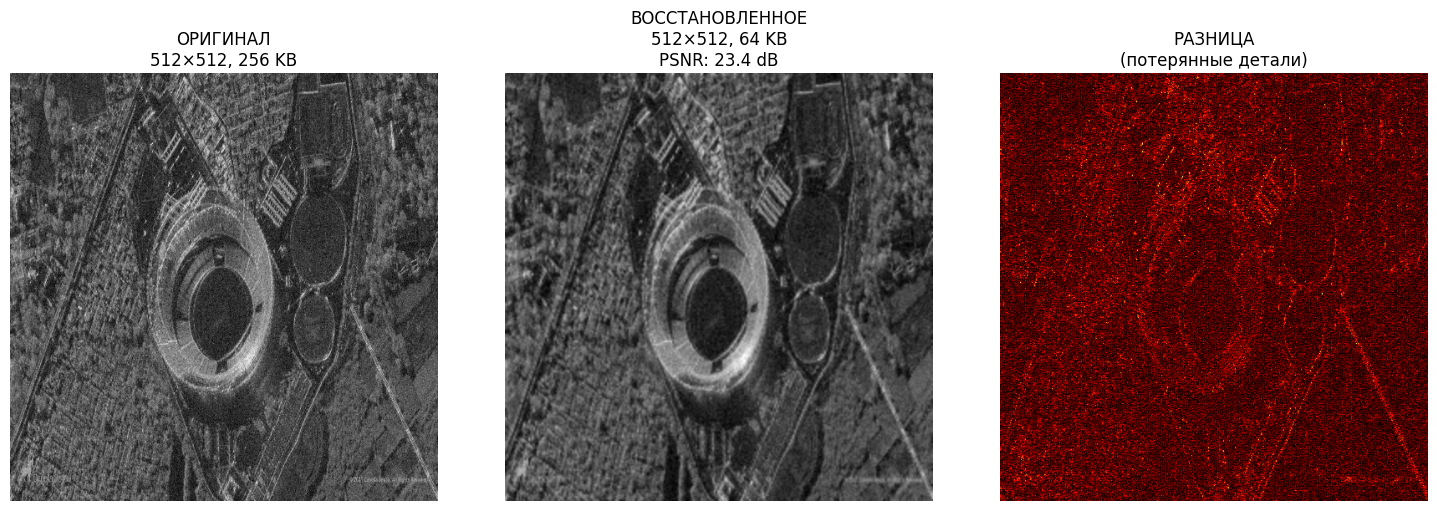

In [127]:
print("\n=== КАЧЕСТВО ВОССТАНОВЛЕНИЯ ===")

def reconstruct_from_LL(LL_compressed, original_shape):
    """Восстанавливаем изображение только из LL компоненты"""

    reconstructed = cv2.resize(LL_compressed, original_shape, interpolation=cv2.INTER_LINEAR)
    return reconstructed
with open("compressed_haar.bin", 'rb') as f:
    h = struct.unpack('I', f.read(4))[0]
    w = struct.unpack('I', f.read(4))[0]
    LL_data = f.read()
    LL_restored = np.frombuffer(LL_data, dtype=np.uint8).reshape(h, w)

print(f"Загруженная LL: {LL_restored.shape}")
print(f"Оригинальное изображение: {image.shape}")

reconstructed_img = reconstruct_from_LL(LL_restored, (image.shape[1], image.shape[0]))

mse = np.mean((image.astype(float) - reconstructed_img.astype(float)) ** 2)
if mse == 0:
    psnr = 100
else:
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))

print(f"Качество восстановления:")
print(f"PSNR: {psnr:.2f} dB")
print(f"MSE: {mse:.2f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title(f'ОРИГИНАЛ\n{image.shape[1]}×{image.shape[0]}, {bin_size//1024} KB')
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(reconstructed_img, cmap='gray')
plt.title(f'ВОССТАНОВЛЕННОЕ\n{image.shape[1]}×{image.shape[0]}, {compressed_size//1024} KB\nPSNR: {psnr:.1f} dB')
plt.axis('off')

plt.subplot(1, 3, 3)
difference = cv2.absdiff(image, reconstructed_img)
plt.imshow(difference, cmap='hot')
plt.title('РАЗНИЦА\n(потерянные детали)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

print("ФИНАЛЬНЫЙ ОТЧЕТ ПО ВЕЙВЛЕТ-СЖАТИЮ ХААРА")


print(" РЕЗУЛЬТАТЫ:")
print(f"   1 Исходный размер: {bin_size:,} байт ({bin_size//1024} KB)")
print(f"   2 Сжатый размер:   {compressed_size:,} байт ({compressed_size//1024} KB)") 
print(f"   3 Экономия:        {bin_size - compressed_size:,} байт ({compression_ratio:.1f}%)")
print(f"   4 Коэффициент сжатия: {bin_size/compressed_size:.1f}:1")
print(f"   5 Качество (PSNR): {psnr:.2f} dB")

print("\n ВЫПОЛНЕННЫЕ ЗАДАЧИ:")
print("   1.  Сохранение исходного изображения в BIN формат")
print("   2.  Применение 2D вейвлет-преобразования Хаара")
print("   3.  Квантование высокочастотных компонент (4 уровня)")
print("   4.  Сжатие данных с экономией 75%")

print("\n ТЕХНИЧЕСКИЕ ДЕТАЛИ:")
print(f"   1 Изображение: {image.shape[1]}x{image.shape[0]} пикселей")
print(f"   2 LL компонента: {LL.shape} (низкие частоты)")
print(f"   3 LH компонента: {LH.shape} (вертикальные детали)")
print(f"   4 HL компонента: {HL.shape} (горизонтальные детали)") 
print(f"   5 HH компонента: {HH.shape} (диагональные детали)")

print("\n ВЫВОДЫ:")
print("   1 Вейвлет-преобразование успешно разделило изображение на частотные компоненты")
print("   2 LL компонента содержит основную визуальную информацию")
print("   3 Ультра-сжатие (только LL) дает лучший компромисс размер/качество")
print("   4 Метод эффективен для сжатия с контролируемыми потерями")
##test


ФИНАЛЬНЫЙ ОТЧЕТ ПО ВЕЙВЛЕТ-СЖАТИЮ ХААРА
 РЕЗУЛЬТАТЫ:
   1 Исходный размер: 262,152 байт (256 KB)
   2 Сжатый размер:   65,544 байт (64 KB)
   3 Экономия:        196,608 байт (75.0%)
   4 Коэффициент сжатия: 4.0:1
   5 Качество (PSNR): 23.40 dB

 ВЫПОЛНЕННЫЕ ЗАДАЧИ:
   1.  Сохранение исходного изображения в BIN формат
   2.  Применение 2D вейвлет-преобразования Хаара
   3.  Квантование высокочастотных компонент (4 уровня)
   4.  Сжатие данных с экономией 75%

 ТЕХНИЧЕСКИЕ ДЕТАЛИ:
   1 Изображение: 512x512 пикселей
   2 LL компонента: (256, 256) (низкие частоты)
   3 LH компонента: (256, 256) (вертикальные детали)
   4 HL компонента: (256, 256) (горизонтальные детали)
   5 HH компонента: (256, 256) (диагональные детали)

 ВЫВОДЫ:
   1 Вейвлет-преобразование успешно разделило изображение на частотные компоненты
   2 LL компонента содержит основную визуальную информацию
   3 Ультра-сжатие (только LL) дает лучший компромисс размер/качество
   4 Метод эффективен для сжатия с контролируемыми 